# Notebook for Project 1

_Jonatan Haraldsson_ [jonhara@chalmers.se](mailto:jonhara@chalmers.se)

_Jesper Noord_ [noord@chalmers.se](mailto:noord@chalmers.se)



In [145]:
# relevant modules for this notebook
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import emcee
import corner
import scipy
from scipy.stats import gamma, invgamma, t, norm, norminvgauss, mode, uniform
import seaborn as sns
import random
#import sklearn
import scipy.constants as const


# LaTeX font
plt.style.use('default')
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 16
plt.rcParams['font.size'] = font_size

c = const.speed_of_light *1e-3
G = const.gravitational_constant

np.random.seed(123)

**Importing the data from SCP 2.1 dataset and exploring data**

In [146]:
data_ = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')
df = pd.DataFrame(data_[:,1:5])  # only keep z, mu, mu_err
df.columns = ["z", "mu", "mu_err", "unknown"]


z = np.array(df['z'])
mu = np.array(df['mu'])
mu_err = np.array(df['mu_err'])
df.head()

,z,mu,mu_err,unknown
0,0.028488,35.346583,0.223906,0.128419
1,0.050043,36.682368,0.166829,0.128419
2,0.052926,36.817691,0.155756,0.128419
3,0.070086,37.446737,0.158467,0.128419
4,0.062668,37.483409,0.156099,0.128419


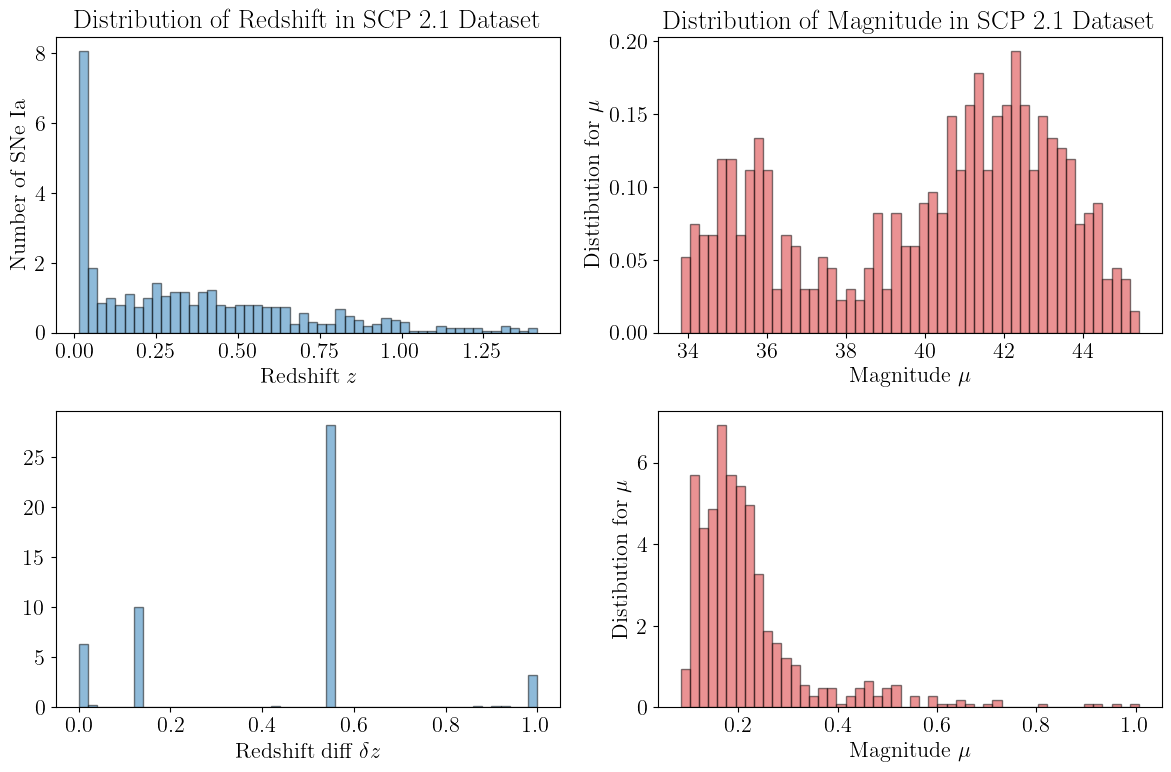

In [147]:
fig,ax = plt.subplots(2,2,figsize=(12,8))
ax[0,0].hist(z, bins=50,density=True,color='tab:blue',alpha=0.5,edgecolor='black')
ax[0,0].set_xlabel('Redshift $z$')
ax[0,0].set_ylabel('Number of SNe Ia')
ax[0,0].set_title('Distribution of Redshift in SCP 2.1 Dataset')
ax[0,1].hist(mu, bins=50,density=True,color='tab:red',alpha=0.5,edgecolor='black')
ax[0,1].set_xlabel('Magnitude $\\mu$')
ax[0,1].set_ylabel('Disttibution for $\\mu$')
ax[0,1].set_title('Distribution of Magnitude in SCP 2.1 Dataset')
ax[0,1].set_xlabel('Magnitude $\\mu$')
ax[0,1].set_ylabel('Disttibution for $\\mu$')
ax[0,1].set_title('Distribution of Magnitude in SCP 2.1 Dataset')


ax[1,0].hist(df['unknown'], bins=50,density=True,color='tab:blue',alpha=0.5,edgecolor='black')
ax[1,0].set_xlabel('Redshift diff $\\delta z$')
#ax[0,0].set_ylabel('Number of SNe Ia')
#ax[0,0].set_title('Distribution of Redshift in SCP 2.1 Dataset')
ax[1,1].hist(mu_err, bins=50,density=True,color='tab:red',alpha=0.5,edgecolor='black')
ax[1,1].set_xlabel('Magnitude $\\mu$')
ax[1,1].set_ylabel('Distibution for $\\mu$')
ax[1,1].set_xlabel('Magnitude $\\mu$')
ax[1,1].set_ylabel('Distibution for $\\mu$')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'All $z$ values')

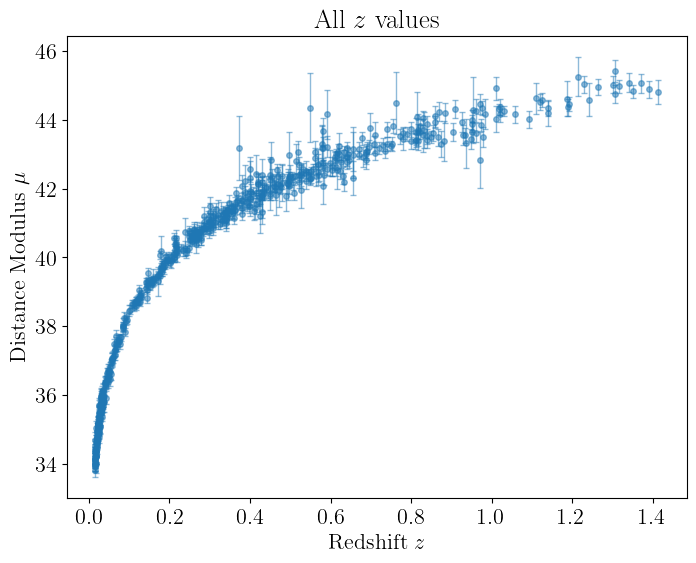

In [148]:
#plt.errorbar(z,mu,yerr=mu_err,color='tab:blue',alpha=0.5)
plt.figure(figsize=(8,6))
plt.errorbar(z,mu,yerr=mu_err,color='tab:blue',alpha=0.5,fmt='o',markersize=4,elinewidth=1,capsize=2)
plt.xlabel('Redshift $z$')
plt.ylabel('Distance Modulus $\\mu$')
plt.title('All $z$ values')

### Filtering in the small-$z$ region

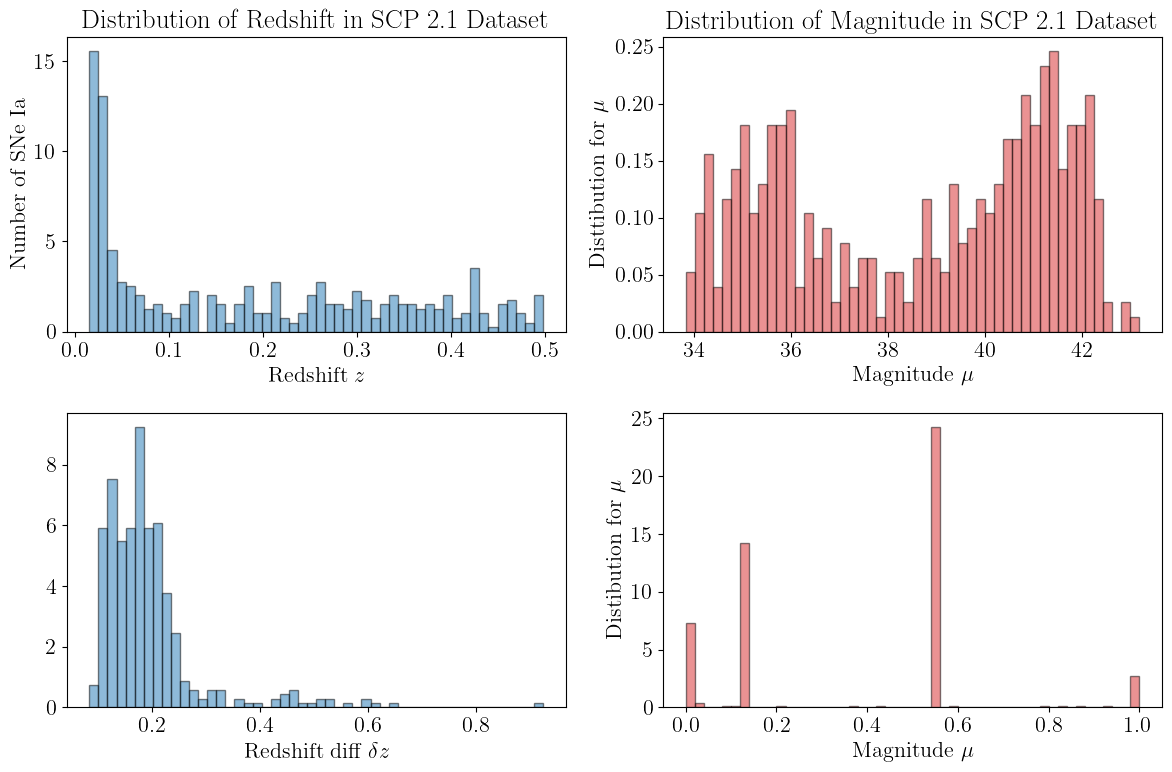

In [149]:
i = df['z'] < 0.5
z_low = np.array(df['z'][i])
mu_low = np.array(df['mu'][i])
mu_err_low = np.array(df['mu_err'][i])
unknown_low = np.array(df['unknown'][i])

fig,ax = plt.subplots(2,2,figsize=(12,8))
ax[0,0].hist(z_low, bins=50,density=True,color='tab:blue',alpha=0.5,edgecolor='black')
ax[0,0].set_xlabel('Redshift $z$')
ax[0,0].set_ylabel('Number of SNe Ia')
ax[0,0].set_title('Distribution of Redshift in SCP 2.1 Dataset')
ax[0,1].hist(mu_low, bins=50,density=True,color='tab:red',alpha=0.5,edgecolor='black')
ax[0,1].set_xlabel('Magnitude $\\mu$')
ax[0,1].set_ylabel('Disttibution for $\\mu$')
ax[0,1].set_title('Distribution of Magnitude in SCP 2.1 Dataset')
ax[0,1].set_xlabel('Magnitude $\\mu$')
ax[0,1].set_ylabel('Disttibution for $\\mu$')
ax[0,1].set_title('Distribution of Magnitude in SCP 2.1 Dataset')


ax[1,0].hist(mu_err_low, bins=50,density=True,color='tab:blue',alpha=0.5,edgecolor='black')
ax[1,0].set_xlabel('Redshift diff $\\delta z$')
#ax[0,0].set_ylabel('Number of SNe Ia')
#ax[0,0].set_title('Distribution of Redshift in SCP 2.1 Dataset')
ax[1,1].hist(unknown_low, bins=50,density=True,color='tab:red',alpha=0.5,edgecolor='black')
ax[1,1].set_xlabel('Magnitude $\\mu$')
ax[1,1].set_ylabel('Distibution for $\\mu$')
ax[1,1].set_xlabel('Magnitude $\\mu$')
ax[1,1].set_ylabel('Distibution for $\\mu$')

plt.tight_layout()
plt.show()

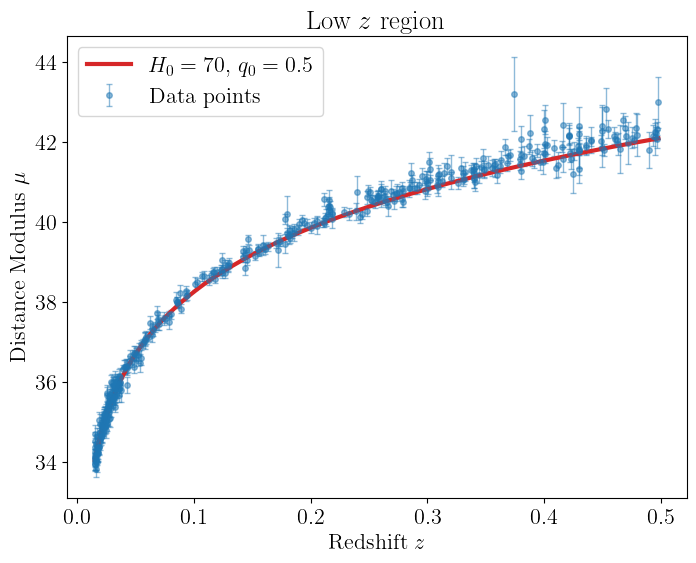

In [150]:
plt.figure(figsize=(8,6))
plt.errorbar(z_low,mu_low,yerr=mu_err_low,color='tab:blue',alpha=0.5,fmt='o',markersize=4,elinewidth=1,capsize=2,label='Data points')
plt.xlabel('Redshift $z$')
plt.ylabel('Distance Modulus $\\mu$')
plt.title('Low $z$ region')
plt.plot(np.sort(z_low),low_z_model(70,np.sort(z_low),0.1),color='tab:red',label='$H_0 = 70$, $q_0 = 0.5$',lw = 3)
plt.legend()

### Defining some useful functions  

In [151]:
def mu_to_d(mu):
    return 10**((mu - 25) / 5)  # in Mpc

def d_to_mu(d):
    if all(i <= 0  for i in d) == False:
        mu = 5 * np.log10(d) + 25
    else:
        print(f'MIN DISTANCE: {np.min(d)}')
        raise ValueError("Distance must be positive.")
    return mu

def rho_crit(H):
    return 3 * H**2 / (8 * np.pi * G)

def get_Om_lam(lam,H):
    return lam / (3 * H**2)

def get_Om_M(lam,H,Om_k = None):
    if Om_k is not None:
        return 1 - Om_k - get_Om_lam(lam,H)
    else:
        return 1 - get_Om_lam(lam,H)
    
def get_q0(Om_M,Om_lam):
    return Om_M / 2 - Om_lam

def get_dl(H_0,z,q_0):
    d = (c / H_0) * (z + (1-q_0) * z**2/2)
    return d

def low_z_model(H,z,q0):
    model = d_to_mu(get_dl(H,z,q0))
    return model

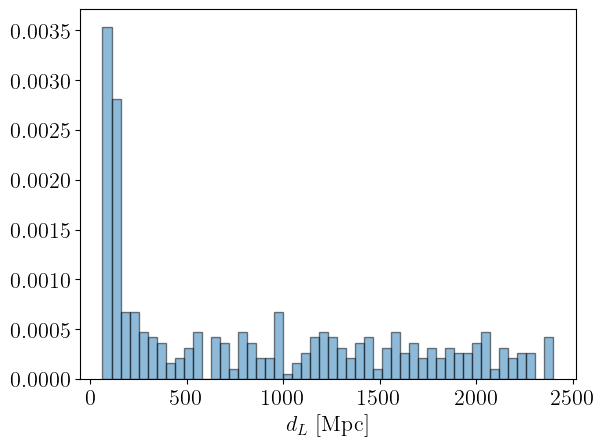

In [152]:
plt.hist(get_dl(70,z_low,0.5), bins=50,density=True,color='tab:blue',alpha=0.5,edgecolor='black')
plt.xlabel('$d_L$ [Mpc]')
plt.show()

### Functions for distributions

In [153]:
def nig_log(th,s2,mu0,Sigma0,alpha,beta):

    if alpha<=0:
        print('error alpha<=0')
        return 0
    if beta<=0:
        print('error beta<=0')
        return 0

    NIG_log = norm.logpdf(th,loc=mu0,scale=np.sqrt(s2)*np.sqrt(Sigma0))+invgamma.logpdf(s2,a=alpha,scale=beta)

    return NIG_log
    
# helper function to convert the IG mean,mode to alpha,beta
def mean_mode_2_IG_alpha_beta(mean,mode):
    alpha = (mode + mean)/(mean-mode)
    beta = (2 * mode * mean)/(mean-mode)
    return alpha, beta

# helper function to convert the G mean,variance to alpha,beta
def mean_variance_2_G_alpha_beta(mean,variance):
    alpha = mean**2/variance
    beta = variance/mean
    return alpha, beta


Your first task is to use $$d_L=\frac{c}{H_0}\left(z + \frac{1}{2}(1-q_0)z^2\right)$$ in the small-$z$ regime $(z < 0.5)$ to extract a joint probability
distribution for $H_0$ and $q_0$. You should use data weights proportional to the measurement errors,
and an inverse gamma prior for the unknown error scale $σ^2$. You can use e.g. uniform priors for
$H0$ and $q0$ if you like.

### $\log$-Prior, $\log$-Likelihood and $\log$-posterior 

Prior is given by $$\mathcal{U}_H[H_{min},H_{max}]\times\mathcal{U}_q[q_{min},q_{max}]\times \mathcal{NIG}(\alpha,\beta,\sigma^2)$$

Likelihood's given by $$\cancel{\left( \frac{1}{2\pi} \right)^{N_d/2}} \frac{1}{|W|^{-1/2}} \exp \left[ -\frac{1}{2} (\mathcal{D} - \boldsymbol{y}_{model})^{T} W (\mathcal{D} - \boldsymbol{y}_{model}) \right],$$ where $$W=\frac{1}{N_d}\begin{bmatrix} 1/\sigma^2_1 & \cdots & 0 \\ \vdots& \ddots & 0 \\ 0 & & 1/\sigma_{N_d}^2 \end{bmatrix}\quad\text{and}\quad\mathcal{D} = \mu \quad \text{and}\quad \boldsymbol{y}_{model}=5\log_{10}\left[\frac{c}{H_0}\left(z + \frac{1}{2}(1-q_0)z^2\right)\right] + 25$$

  

In [171]:
def log_likelihood(theta, z, mu, sig_mu):
    '''
    z - found in data frame
    mu - found in data frame
    sig_m - found in data frame
    '''
    H0 = theta[0]#.flatten()
    q0 = theta[1]#.flatten()
    s2 = sig_mu
    Nd = len(mu)
    w = 1 / s2 * (1 / Nd)
    W = np.diag(w)
    #print(np.max(W))
    y = mu
    model = d_to_mu(get_dl(H0,z,q0))
    
    log_like = -0.5 * (y - model).T @ W @ (y - model)/theta[2] + 0.5 * np.linalg.det(W) - Nd * (np.sum(np.log(2 * np.pi * theta[2]))/2)

    return log_like#, y[0], model[0]

def log_prior(theta,a0, b0, H0_lims = [50,100], q0_lims = [-2,2]):

    H0 = theta[0]#.flatten()
    q0  = theta[1]#.flatten()
    sig2 = theta[2]#.flatten()

    H0_min = H0_lims[0]; H0_max = H0_lims[1]
    q0_min = q0_lims[0];  q0_max = q0_lims[1]

    log_H = uniform.logpdf(H0, loc=H0_min, scale=H0_max - H0_min)

    log_q = uniform.logpdf(q0, loc = q0_min, scale = q0_max - q0_min)

    log_th = log_q + log_H

    log_IG = invgamma.logpdf(sig2,a=a0, scale=b0)  

    #log_N  = norm.logpdf(0,loc=mu0,scale=np.sqrt(sig2)*np.sqrt(Sigma_0[0]))
    lp = log_th + log_IG# + log_N
    
    return lp


def log_posterior(theta, z, mu, sig_m, a0, b0):

    log_like = log_likelihood(theta, z, mu, sig_m)
    log_pri = log_prior(theta, a0, b0)
    
    log_post = log_like + log_pri
    if np.isnan(log_post):
        return -np.inf
    
    return log_post

In [172]:
IG_mean = 10
IG_mode = 0.5
a0, b0  = mean_mode_2_IG_alpha_beta(IG_mean,IG_mode)

print(log_prior(np.array([70,0.5,0.05**2]),a0,b0))

-413.6285638603839


Text(0, 0.5, '$q_0$')

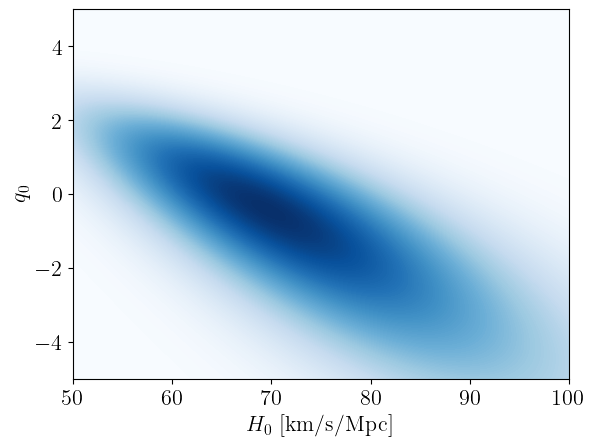

In [ ]:

H0_grid = np.linspace(50,100,len(z_low))
q0_grid = np.linspace(-5,5,len(H0_grid))

H0, q0 = np.meshgrid(H0_grid,q0_grid)

z = z_low
mu = mu_low
sig = mu_err_low

#z = unknown_low

n = 0
like = np.zeros((len(q0_grid),len(H0_grid)))
sum_like = 0
for q_i,i in zip(q0_grid, range(len(q0_grid))):
    for H_i,j in zip(H0_grid, range(len(H0_grid))):
        lh = log_likelihood([H_i,q_i,0.5], z, mu, sig)
        like[i,j] = np.exp(lh)


"""post_pdf = np.zeros_like(grid)
for th_idx, th_val in enumerate(H0):
    for s2_idx, s2_val in enumerate(q0):
        post_pdf[s2_idx][th_idx] = log_posterior([th_val,s2_val], z, mu, sig)"""



plt.contourf(H0, q0, like, levels=200, cmap='Blues')#,alpha=0.5)
plt.xlabel('$H_0$ [km/s/Mpc]')
plt.ylabel('$q_0$')

#print(log_posterior(th,z,mu,sig))


Text(0, 0.5, '$q_0$')

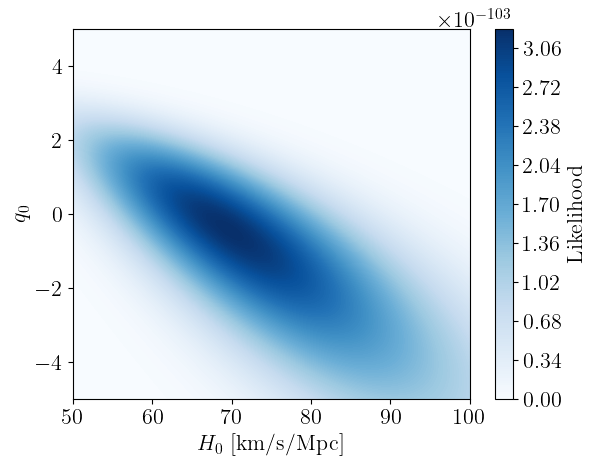

In [174]:
plt.contourf(H0, q0, like, levels=200, cmap='Blues')#,alpha=0.5)
plt.colorbar(label='Likelihood')
plt.xlabel('$H_0$ [km/s/Mpc]')
plt.ylabel('$q_0$')

Text(0, 0.5, '$q_0$')

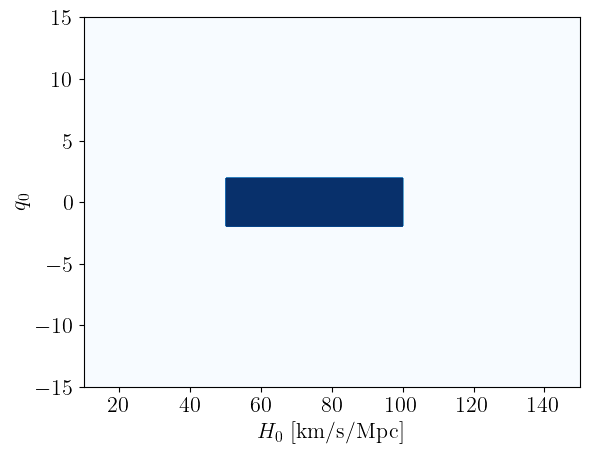

In [175]:
H0_grid = np.linspace(10,150,len(z_low))
q0_grid = np.linspace(-15,15,len(H0_grid))

H0, q0 = np.meshgrid(H0_grid,q0_grid)

HQ_grid = np.dstack((H0,q0))
grid = HQ_grid.reshape(-1,2)

z = z_low
mu = mu_low
sig = mu_err_low

n = 0
pri = np.zeros((len(q0_grid),len(H0_grid)))

for q_i,i in zip(q0_grid, range(len(q0_grid))):
    for H_i,j in zip(H0_grid, range(len(H0_grid))):
        lp = log_prior([H_i,q_i,0.1], a0, b0)
        pri[i,j] = np.exp(lp)


plt.contourf(H0, q0, pri, levels=200, cmap='Blues')#,alpha=0.5)
plt.xlabel('$H_0$ [km/s/Mpc]')
plt.ylabel('$q_0$')

# prior_pdf = np.zeros((len(H0_grid),len(q0_grid)))
# for H_i,H_val in enumerate(H0_grid):
#     for q_i,q_val in enumerate(q0_grid):
#         prior_pdf[q_i][H_i] = log_posterior([H_val,q_val,0.05**2],z,mu,sig, mu0, Sigma0,a0,b0)

# plt.contourf(H0, q0, np.exp(prior_pdf) , levels=200, cmap='Blues')#,alpha=0.5)
#print(log_posterior(th,z,mu,sig))


In [176]:
H0_grid = np.linspace(10,150,len(z_low))
sigma_sample = np.linspace(0,10,len(H0_grid))

H0, sigm = np.meshgrid(H0_grid,sigma_sample)


z = z_low
mu = mu_low
sig = mu_err_low

n = 0
pri = np.zeros((len(sigma_sample),len(H0_grid)))

for s,i in zip(sigma_sample, range(len(sigma_sample))):
    for H_i,j in zip(H0_grid, range(len(H0_grid))):
        lp = log_prior([H_i,0.5,s], a0, b0)
        pri[i,j] = np.exp(lp)


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/cc/g7htxfj57sq65d7g1185yzwr0000gn/T/ipykernel_21016/4093061105.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma^2$')


Text(0, 0.5, '$\\sigma^2$')

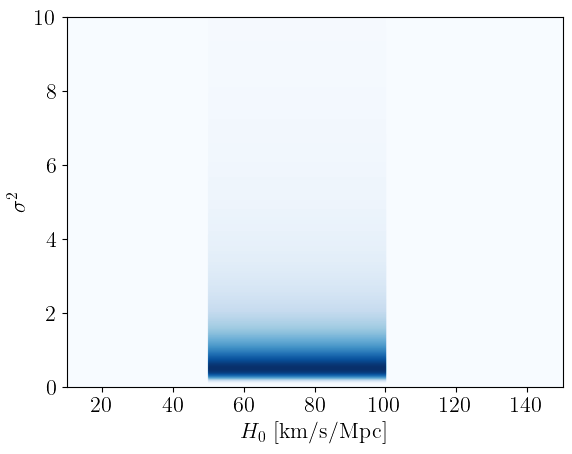

In [177]:
plt.contourf(H0, sigm, pri, levels=200, cmap='Blues')#,alpha=0.5)
plt.xlabel('$H_0$ [km/s/Mpc]')
plt.ylabel('$\sigma^2$')

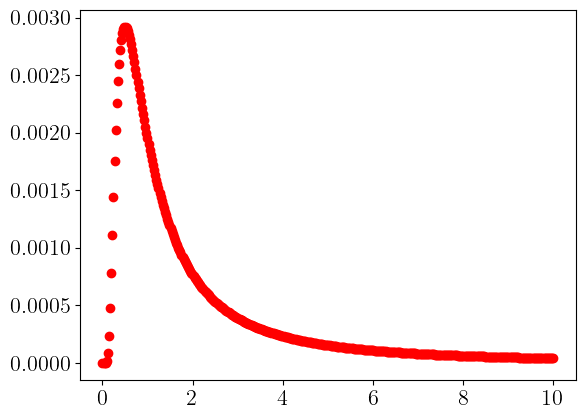

In [178]:

for s in sigma_sample:
    lp = log_prior([70,0.5,s], a0, b0)
    plt.scatter(s,np.exp(lp),c='red')

### MCMC sampling
Here we go again!! 

In [179]:
def samples_MCMC(q0_lims, H0_lims, post,x, y, sigma ,nwalkers, burninproc =10 , iterations = 10000):
    """
    Sets up an MCMC sampler with initial positions for the walkers.

    Args:
        theta_0_lims (list): Minimum and maximum boundary for starting position in theta0.
        theta_1_lims (list): Minimum and maximum boundary for starting position in theta1.
        x (array): Independent data.
        y (array): Dependent data.
        post (callable): Function to compute the log-posterior or log-likelihood.
        nwalkers (int): Number of MCMC walkers.

    Returns:
        sampler (emcee.EnsembleSampler): Initialized MCMC sampler object.
    """
    
    ndim = 3  # Since theta has three parameters: [intercept, slope,sigma]

    rng = np.random.default_rng(seed = 1337)


    q   = rng.uniform(q0_lims[0],q0_lims[1],size = nwalkers)
    H   = rng.uniform(H0_lims[0],H0_lims[1],size = nwalkers)
    sig = rng.uniform(0.1,10,size = nwalkers)

    p0 = np.vstack((q,H,sig)).T

    burnin = int(burninproc*iterations/100)

    # Set up the MCMC sampler with the log posterior function
    sampler_post = emcee.EnsembleSampler(nwalkers, ndim, post, args = (x, y, sigma, a0, b0))
    new_pos, prob, state = sampler_post.run_mcmc(p0, burnin, progress=True)

    run = sampler_post.run_mcmc(new_pos, iterations)#, progress=True)
    samples = sampler_post.get_chain(discard = burnin,flat = True)

    return samples

In [180]:
x = z_low
y = mu_low
sig = mu_err_low

H0_lims = [50,90]
q0_lims = [-2,2]

samples = samples_MCMC(H0_lims,q0_lims,log_posterior,x,y,
                                 sigma = sig,iterations=int(5e3),nwalkers=10)

  0%|          | 0/500 [00:00<?, ?it/s]

/var/folders/cc/g7htxfj57sq65d7g1185yzwr0000gn/T/ipykernel_21016/670904863.py:17: RuntimeWarning: invalid value encountered in log
  log_like = -0.5 * (y - model).T @ W @ (y - model)/theta[2] + 0.5 * np.linalg.det(W) - Nd * (np.sum(np.log(2 * np.pi * theta[2]))/2)
100%|██████████| 500/500 [00:04<00:00, 108.09it/s]


In [181]:
print('Number of samples',len(samples))

Number of samples 50000


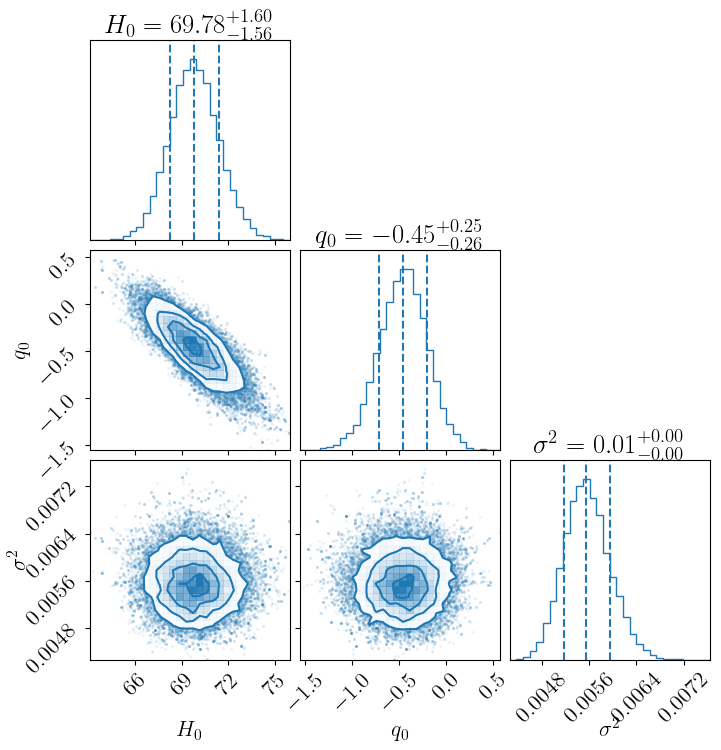

In [182]:
fig = corner.corner(samples, labels=[r"$H_0$", r"$q_0$",r"$\sigma^2$"], color='tab:blue',
                show_titles=True, bins=30, plot_contours=True, plot_datapoints=True, 
                plot_density=True,quantiles=[0.16,0.5,0.84])#,truths = [intercept,slope,sigma])

In [183]:
def running_mean(x, factor=0.02):
    """
    Return the running mean of N element in a list.

    Args:
        x (ndarray): The list of elements,
        factor (float): The factor to multiply the length of the list by.
    
    Returns:
        ndarray: The running mean.
    """
    it, walker = x.shape
    N = int(factor * it)
    average = np.zeros((it - N+1,walker))
    #print(average.shape)
    for i in range(walker):
        cumsum = np.cumsum(np.insert(x[:,i], 0, 0))
        #print((cumsum[N:] - cumsum[:-N]).shape)
        average[:,i] = ((cumsum[N:] - cumsum[:-N]) / float(N))
   # average = np.sum(average,axis=1)

    return average


def trace_plotter(samples):
    ndim = samples.shape[1]
    fig, axes = plt.subplots(ndim, figsize=(4*ndim, 3*ndim), sharex=True)
    labels = [r"$H_0$", r"$q_0$", r"$\sigma^2$"]
    mean = running_mean(samples)
    for i in range(3):
        ax = axes[i]
        ax.plot(samples[:, i], "k", alpha=0.3)
        ax.plot(np.arange(len(mean)), mean[:,i], color='tab:red')
        ax.set_ylabel(labels[i])

    axes[-1].set_xlabel("step number");

    plt.show()



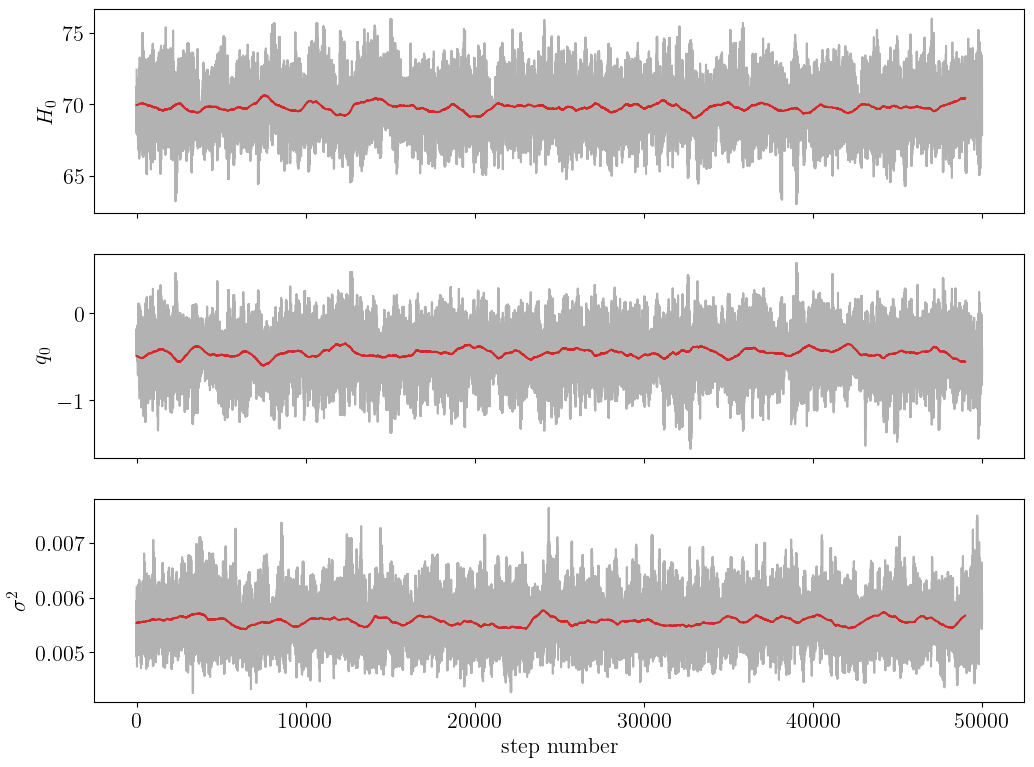

In [184]:
trace_plotter(samples)

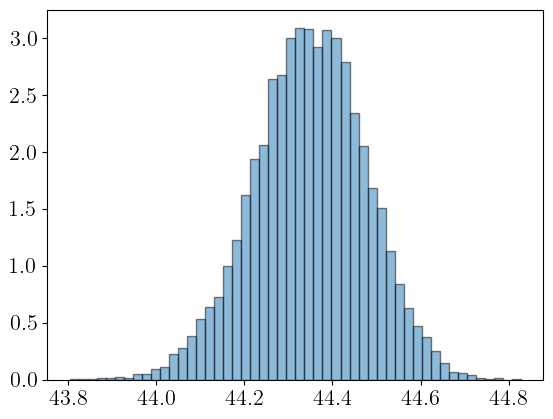

In [185]:
H = samples[:,0]
q = samples[:,1]
sigma = samples[:,2]
z = 1

ppd_hist = low_z_model(H, z, q)

plt.hist(ppd_hist, bins=50, density=True, color='tab:blue', alpha=0.5, edgecolor='black');

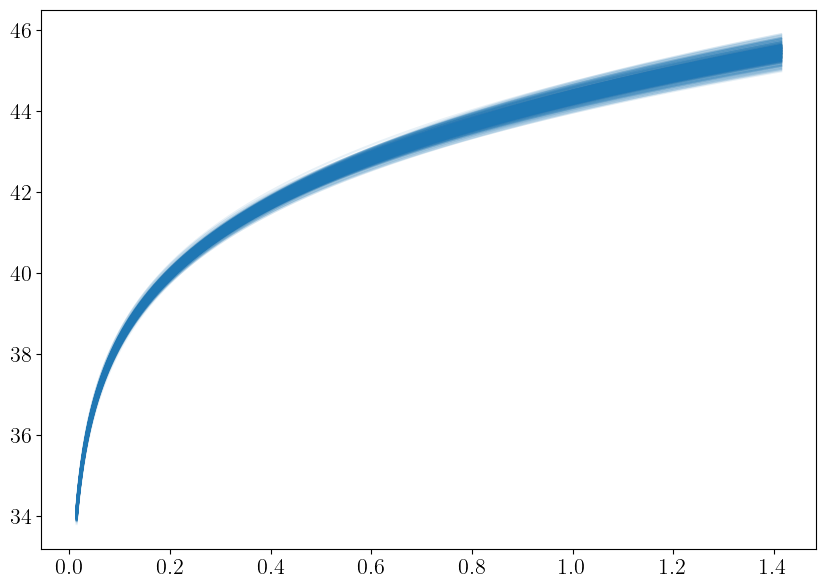

In [186]:
Nsamp = 500
sample_idx = random.sample(range(0, len(samples)), Nsamp)

z_ = np.linspace(np.min(df['z']), np.max(df['z']), len(df['z']))
plt.figure(figsize=(10,7))
#plt.scatter(z, mu, s=10, color='tab:black', alpha=0.5, label='SCP 2.1 Data')

for idx in sample_idx:
    H_i = samples[idx,0]
    q_i = samples[idx,1]
    mu_hat = low_z_model(H_i, z_, q_i) + np.random.normal(0,np.sqrt(samples[idx,2]))
    plt.plot(z_, mu_hat, color='tab:blue', alpha=0.1)


# plt.xlim(0.4, 0.55)
# plt.ylim(41.5, 42.5)